### (PSL) Project 1

#### Member
| Field         | Value                |
|---------------|----------------------|
| Name          | Lee Yu Chung, Paul   |
| UID           | 665451160            |
| NetID         | ycl7                 |
| Program       | MCS-DS               |
| Contributions | 100%                 |



### Dataset Origin
The training and test splits are derived from the Ames Housing data. For more background on this dataset, you can refer to:

- De Cock, D. (2011). “Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project,” Journal of Statistics Education, Volume 19, Number 3. [PDF]

- Check variable description [Here]

- This dataset also features in a Kaggle competition (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Our dataset, however, has two additional explanatory variables: “Longitude” and “Latitude”. Exploring the Kaggle competition can offer insights on data analysis approaches and sample codes.

### Project Objective
Your task is to predict the price of homes, but importantly, in log scale. You need to build TWO prediction models selected from the following two categories:

- one based on linear regression models with Lasso or Ridge or Elasticnet penalty;
- one based on tree models, such as randomForest or boosting tree.

**Note:**
- The features selected for the two models can differ.
- PID cannot be used as a feature. PID is a unique identifier for parcels of land or properties assigned by the county. It’s more like an index and has no logical connection to housing price determinants.
- Please refer to Campuswire to identify the packages that are permissible for use in this project.


In [1]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.stats import skew, pearsonr
import warnings
warnings.filterwarnings('ignore')

# set random seed
seed_val = 1160
np.random.seed(seed_val)

#### Data preprocessing
- Load: Loading the data from CSV files
- Clean: data cleansing to remove errors or inconsistencies
- Impute: Impute any missing values
- Encode: Encoding the statistical data type (numeric, categorical)

#### Load

In [2]:
# Targeted directory
target_fold_dir = 'fold1'
# import the fold1 data
X_train_full = pd.read_csv(f'{target_fold_dir}/train.csv', index_col='PID')
X_train = X_train_full.iloc[:, 1:-1] # exclude the first column and the last two columns
y_train = np.log(X_train_full.iloc[:, -1])

# import the test data
X_test_full = pd.read_csv(f'{target_fold_dir}/test.csv', index_col='PID')
test_data_y = pd.read_csv(f'{target_fold_dir}/test_y.csv', index_col='PID')

X_test = X_test_full.iloc[:, 1:] # exclude the first column and the last two columns
y_test = np.log(test_data_y.iloc[:, -1])

In [3]:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

y_train_processed = y_train.copy()
y_test_processed = y_test.copy()

Drop 19 rows


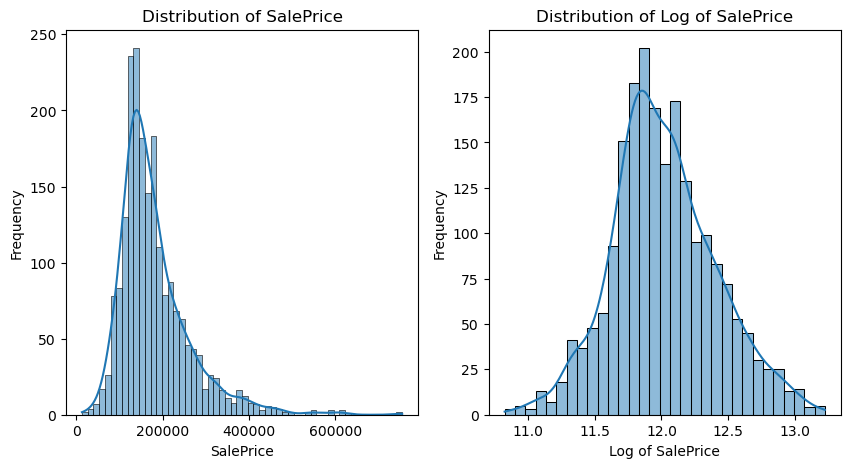

In [4]:
# plot the sales price distribution (original, log)

y_train_original = X_train_full.iloc[:, -1]

# drop the rows with extreme price larger
mean = y_train.mean()
std = y_train.std()    
rows_to_drop = y_train[(y_train > mean + 3 * std) | (y_train < mean - 3 * std)].index
print(f'Drop {len(rows_to_drop)} rows')
X_train_processed = X_train_processed.drop(index=rows_to_drop)
y_train_processed = y_train_processed.drop(index=rows_to_drop)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(y_train_original, kde=True, ax=axs[0]) 
axs[0].set_title('Distribution of SalePrice')
axs[0].set_xlabel('SalePrice')
axs[0].set_ylabel('Frequency')

sns.histplot(y_train_processed, kde=True, ax=axs[1]) 
axs[1].set_title('Distribution of Log of SalePrice')
axs[1].set_xlabel('Log of SalePrice')
axs[1].set_ylabel('Frequency')

plt.show()

#### Clean

In [5]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
    max_year = 2011 # the max year of the training data
    # corrupted Garage_Yr_Blt = less than Year_Built or nan
    df['Garage_Yr_Blt'] = df['Garage_Yr_Blt'].apply(lambda x: x if x <= max_year else np.nan)
    df['Garage_Yr_Blt'] = df['Garage_Yr_Blt'].fillna(df['Year_Built'])
    return df
X_train_processed = clean(X_train_processed)
X_test_processed = clean(X_test_processed)

#### Preprocess Numeric Features
log transform skewed numeric features

In [6]:
#log transform skewed numeric features:
numeric_feats = X_train_processed.dtypes[X_train_processed.dtypes != "object"].index

skewed_feats = X_train_processed[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

X_train_processed[skewed_feats] = np.log1p(X_train_processed[skewed_feats])
X_test_processed[skewed_feats] = np.log1p(X_test_processed[skewed_feats])

#### Encode Categorical Features

                          MS_Zoning Street            Alley  \
PID                                                           
526350040  Residential_High_Density   Pave  No_Alley_Access   
526351010   Residential_Low_Density   Pave  No_Alley_Access   
527105010   Residential_Low_Density   Pave  No_Alley_Access   
527105030   Residential_Low_Density   Pave  No_Alley_Access   
527127150   Residential_Low_Density   Pave  No_Alley_Access   

                    Lot_Shape Land_Contour Utilities Lot_Config Land_Slope  \
PID                                                                          
526350040             Regular          Lvl    AllPub     Inside        Gtl   
526351010  Slightly_Irregular          Lvl    AllPub     Corner        Gtl   
527105010  Slightly_Irregular          Lvl    AllPub     Inside        Gtl   
527105030  Slightly_Irregular          Lvl    AllPub     Inside        Gtl   
527127150             Regular          Lvl    AllPub     Inside        Gtl   

          N

<Axes: xlabel='None', ylabel='None'>

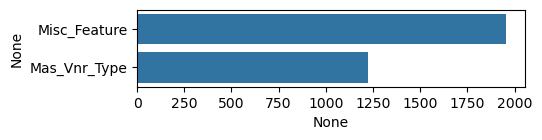

In [7]:
train_c=X_train_processed[[c for c in X_train_processed.columns if X_train_processed[c].dtypes=='O']].copy()
test_c=X_test_processed[[c for c in X_test_processed.columns if X_test_processed[c].dtypes=='O']].copy()
print(train_c.head())
print(test_c.head())
# print(train_c.shape)
fig=plt.figure(figsize=(5,1))
train_null=train_c.isnull().sum()[train_c.isnull().sum()!=0].sort_values(ascending=False)
sns.barplot(y=train_null.index,x=train_null)

In [8]:
# dropping the rows with missing values in the categorical features
X_train_processed = X_train_processed.drop(columns=train_null.index)
X_test_processed = X_test_processed.drop(columns=train_null.index)

In [9]:
def label_encoding(df: pd.DataFrame) -> pd.DataFrame:
    le = LabelEncoder()
    for col in df.select_dtypes(exclude=['number']).columns:
        df[col] = le.fit_transform(df[col])
    return df

In [10]:
X_train_processed = label_encoding(X_train_processed)
X_test_processed = label_encoding(X_test_processed)

# verify the data
display(X_train_processed.info())
display(X_train_processed.head())
display(X_test_processed.info())
display(X_test_processed.head())


<class 'pandas.core.frame.DataFrame'>
Index: 2032 entries, 526350040 to 924151050
Data columns (total 78 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_Zoning           2032 non-null   int64  
 1   Lot_Frontage        2032 non-null   int64  
 2   Lot_Area            2032 non-null   float64
 3   Street              2032 non-null   int64  
 4   Alley               2032 non-null   int64  
 5   Lot_Shape           2032 non-null   int64  
 6   Land_Contour        2032 non-null   int64  
 7   Utilities           2032 non-null   int64  
 8   Lot_Config          2032 non-null   int64  
 9   Land_Slope          2032 non-null   int64  
 10  Neighborhood        2032 non-null   int64  
 11  Condition_1         2032 non-null   int64  
 12  Condition_2         2032 non-null   int64  
 13  Bldg_Type           2032 non-null   int64  
 14  House_Style         2032 non-null   int64  
 15  Overall_Qual        2032 non-null   int64  
 16

None

,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,...,Pool_Area,Pool_QC,Fence,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
PID,,,,,,,,,,,,,,,,,,,,,
526350040,4,80,9.360741,1,1,2,3,0,4,0,...,0.0,2,2,0.000000,6,2010,9,4,-93.619756,42.053014
526351010,5,81,9.565775,1,1,3,3,0,0,0,...,0.0,2,4,9.433564,6,2010,9,4,-93.619387,42.052659
527105010,5,74,9.534668,1,1,3,3,0,4,0,...,0.0,2,2,0.000000,3,2010,9,4,-93.638933,42.060899
527105030,5,78,9.208238,1,1,3,3,0,4,0,...,0.0,2,4,0.000000,6,2010,9,4,-93.638925,42.060779
527127150,5,41,8.501267,1,1,2,3,0,4,0,...,0.0,2,4,0.000000,4,2010,9,4,-93.633792,42.062978


<class 'pandas.core.frame.DataFrame'>
Index: 879 entries, 908276150 to 527225035
Data columns (total 78 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_Zoning           879 non-null    int64  
 1   Lot_Frontage        879 non-null    int64  
 2   Lot_Area            879 non-null    float64
 3   Street              879 non-null    int64  
 4   Alley               879 non-null    int64  
 5   Lot_Shape           879 non-null    int64  
 6   Land_Contour        879 non-null    int64  
 7   Utilities           879 non-null    int64  
 8   Lot_Config          879 non-null    int64  
 9   Land_Slope          879 non-null    int64  
 10  Neighborhood        879 non-null    int64  
 11  Condition_1         879 non-null    int64  
 12  Condition_2         879 non-null    int64  
 13  Bldg_Type           879 non-null    int64  
 14  House_Style         879 non-null    int64  
 15  Overall_Qual        879 non-null    int64  
 16 

None

,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,...,Pool_Area,Pool_QC,Fence,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
PID,,,,,,,,,,,,,,,,,,,,,
908276150,4,0,9.096836,1,1,3,3,0,0,0,...,0.0,2,2,0.0,10,2009,0,0,-93.663302,42.018592
903451090,5,57,8.835938,1,1,2,3,0,4,0,...,0.0,2,2,0.0,8,2009,8,4,-93.628299,42.025306
527110080,4,0,9.537484,1,1,1,3,0,0,0,...,0.0,2,4,0.0,7,2007,8,4,-93.636146,42.061664
535457010,4,87,9.210440,1,1,3,3,0,0,0,...,0.0,2,4,0.0,2,2010,8,4,-93.605943,42.034748
903484020,5,60,9.241936,1,0,2,3,0,4,0,...,0.0,2,2,0.0,6,2008,8,4,-93.624580,42.023716


#### Impute
When imputing missing values, it’s important to understand that some NaN values in the dataset represent "None" rather than truly missing or null values. These instances occur when the absence of a value has meaning, such as indicating the non-existence of a particular feature.

These Features are : 'PoolQC','BsmtQual', 'BsmtCond', 'BsmtExposure', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Alley', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'GarageType', , 'MiscFeature'

In [11]:
def impute(df: pd.DataFrame) -> pd.DataFrame:
    # Vsiualize the percentages of missing values per features:
    missing_values = pd.DataFrame({'Percentage': (df.isnull().sum()/len(df)) * 100},
                                  index=df.columns)
    missing_values = missing_values[missing_values['Percentage'] > 0].sort_values(
        by='Percentage',
        ascending=False)
    missing_values.head(10)

    nan_cols = missing_values.index.tolist()
    print(nan_cols)

    for col in nan_cols:
        df[col] = df[col].fillna('None')
    return df

X_train_processed = impute(X_train_processed)
X_test_processed = impute(X_test_processed)

[]
[]


### Metric Function

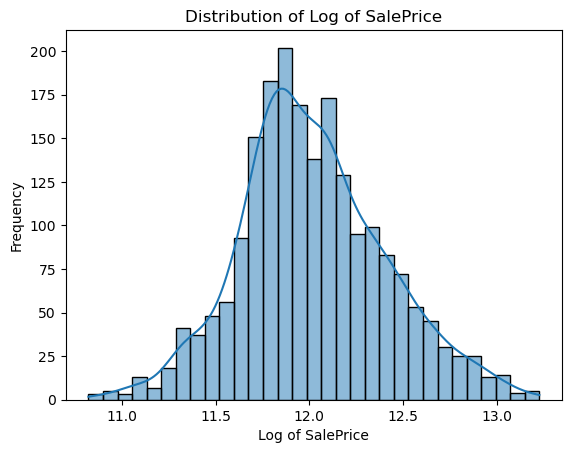

In [12]:
# Distribution of the target variable
sns.histplot(y_train_processed, kde=True) 
plt.title('Distribution of Log of SalePrice')
plt.xlabel('Log of SalePrice')
plt.ylabel('Frequency')
plt.show()

In [13]:
# def score_model(X: pd.DataFrame, y: pd.Series, model=XGBRegressor()) -> float:
#     # Metric for Housing competition is RMSE (Root Mean Squared Error)
#     score = cross_val_score(
#         model, X, y, cv=10, scoring="neg_root_mean_squared_error",
#     )
#     score = -1 * score.mean()
#     return score
# baseline_score = score_model(X_train, y_train)
# print(f"Baseline score: {baseline_score:.5f} RMSE")


def score_model(y_test: pd.Series, y_pred: pd.Series) -> float:    
    # Method2: direct calculation
    return np.sqrt(np.mean((y_pred - y_test) ** 2))

### Select the optimal span

In [14]:
# branch out the full training data into full and optimal span
X_train_opt = X_train_processed.copy()
y_train_opt = y_train_processed.copy()

X_test_opt = X_test_processed.copy()
y_test_opt = y_test_processed.copy()

#### Mutual Information
Mutual Information (MI) and correlation both measure relationships between variables, but MI captures both linear and non-linear dependencies, while correlation only detects linear relationships.

Correlation is simple to interpret, ranging from -1 to 1, and works well for continuous numerical data with linear dependencies. MI, on the other hand, can handle both categorical and continuous data, detecting more complex relationships but is less intuitive and computationally more expensive.

In [15]:
from sklearn.feature_selection import mutual_info_regression

# Function to calculate mi_scores:
def make_mi_scores(X, y):
    X = X.copy()
    # Encode categorical features:
    # All discrete features should now have integer dtypes
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # extract discrete features:
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, 
                                      discrete_features=discrete_features,
                                      random_state=0)
    # Store mi scores in a serie
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    # Sort the mi scores
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [16]:
scores_mi = make_mi_scores(X_train_opt, y_train_opt)
print(scores_mi)

Neighborhood    0.592456
Overall_Qual    0.581809
Garage_Area     0.494113
Gr_Liv_Area     0.469031
Longitude       0.462683
                  ...   
BsmtFin_SF_2    0.000000
Mo_Sold         0.000000
Pool_QC         0.000000
Utilities       0.000000
Land_Slope      0.000000
Name: MI Scores, Length: 78, dtype: float64


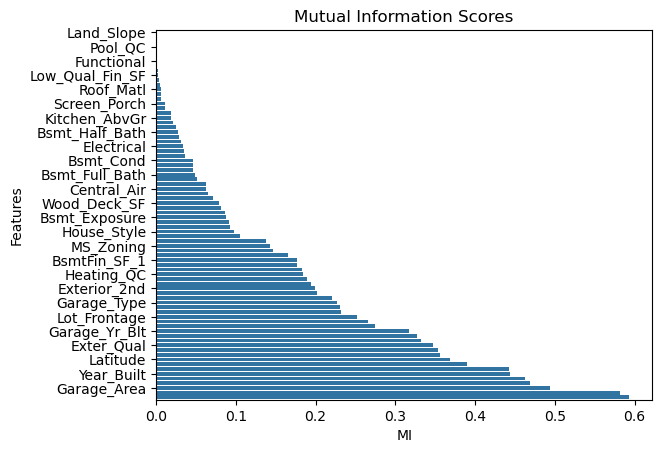

In [17]:
# Function to plot the mi_scores:
def plot_mi_scores(scores):
    # sort the scores:
    scores = scores.sort_values(ascending=True)
    sns.barplot(x=scores, y=scores.index)
    plt.xlabel('MI')
    plt.ylabel('Features')
    plt.title('Mutual Information Scores')
    # Set y-axis tick locations and labels
    tick_locations = range(0, len(scores.index), 3)  # every 2 units
    tick_labels = scores.index[tick_locations]
    plt.yticks(tick_locations, tick_labels)
plot_mi_scores(scores_mi)

In [18]:
# Function to drop uninformative features:
def drop_uninformative(df, mi_scores):
    # drop the features with MI scores less than 0.0
    print(f"Dropping features with MI scores less than 0.0: {mi_scores[mi_scores == 0.0].index.tolist()}")
    return df.loc[:, mi_scores > 0.01]

X_train_opt = drop_uninformative(X_train_opt, scores_mi)
X_test_opt = drop_uninformative(X_test_opt, scores_mi)

Dropping features with MI scores less than 0.0: ['BsmtFin_SF_2', 'Mo_Sold', 'Pool_QC', 'Utilities', 'Land_Slope']
Dropping features with MI scores less than 0.0: ['BsmtFin_SF_2', 'Mo_Sold', 'Pool_QC', 'Utilities', 'Land_Slope']


#### Correlation
Correlation between numerical features and a target variable is a statistical measure that indicates the strength and direction of a linear relationship between them. In predictive modeling, understanding this correlation is crucial, as it helps identify which features significantly impact the target variable. A strong positive correlation suggests that as one feature increases, the target variable tends to increase as well, while a strong negative correlation indicates that an increase in the feature corresponds to a decrease in the target variable.

In [ ]:
# correlation between the features and the target
# concatenate the features and the target
X_train_corr = pd.concat([X_train_opt, y_train_opt], axis=1)
corr_matrix = X_train_corr.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# drop the features with low correlation with the target
corr_threshold = 0.05
drop_cols = X_train_corr.columns[X_train_corr.corr()['Sale_Price'] < corr_threshold]
print("Dropped columns:", drop_cols)
X_train_opt = X_train_opt.drop(columns=drop_cols)
X_test_opt = X_test_opt.drop(columns=drop_cols)


In [ ]:
# recompute the correlation matrix
X_train_opt_corr = pd.concat([X_train_opt, y_train_opt], axis=1)
corr_matrix_opt = X_train_opt_corr.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_opt, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
plt.figure(figsize=(5,10))
sns.heatmap(corr_matrix_opt[['Sale_Price']].sort_values(by=['Sale_Price'],ascending=False).head(30),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
plt.show()

**Co-linearity**

We will choose only one feature from each co-linear pair.

In [ ]:
# find out all hightly correlated features (colinear pairs)
highly_correlated_threshold = 0.8
highly_correlated_matrix = corr_matrix_opt[corr_matrix_opt > highly_correlated_threshold]
highly_correlated_matrix = highly_correlated_matrix[highly_correlated_matrix < 1]

# print the correlated pairs (not nan)
correlated_pairs = set()

target = 'Sale_Price'
for p1 in highly_correlated_matrix.columns:
    # check if the correlation contains nan
    if pd.notna(highly_correlated_matrix[p1]).any():
        # print the correlated features
        p2_list = highly_correlated_matrix[p1].dropna().index.tolist()
        for p2 in p2_list:
            # Create a sorted tuple of the pair to ensure uniqueness
            pair = tuple(sorted([p1, p2]))
            if pair not in correlated_pairs:
                print(f"{pair[0]} and {pair[1]}")
                print(f"  {p1} and {p2} correlation: {highly_correlated_matrix[p1][p2]:.3f}")
                print(f"  {target} and {p1} correlation: {corr_matrix_opt[target][p1]:.3f}")
                print(f"  {target} and {p2} correlation: {corr_matrix_opt[target][p2]:.3f}")
                correlated_pairs.add(pair)

print(f"Number of correlated pairs: {len(correlated_pairs)}")

In [ ]:
fig, ax = plt.subplots(len(correlated_pairs), 2, figsize=(7, 10))
for i, pair in enumerate(correlated_pairs):
    print(i, pair)
    sns.scatterplot(x = 'Sale_Price', y = pair[0], data=X_train_corr, ax=ax[i][0])
    sns.scatterplot(x = 'Sale_Price', y = pair[1], data=X_train_corr, ax=ax[i][1])

fig.tight_layout()

In [25]:
# According to the scatter plots, we will drop the features with lower correlation with the target
drop_cols = ['Garage_Yr_Blt', 'Garage_Cars', 'TotRms_AbvGrd', 'House_Style']
X_train_opt = X_train_opt.drop(columns=drop_cols)
X_test_opt = X_test_opt.drop(columns=drop_cols)

#### Remove non-linear features
We have removed co-linearity from our dataset, Now we will manually examine each feature and remove non-linear features from the dataset

In [ ]:
print(X_train_opt.columns, len(X_train_opt.columns))
fig, ax = plt.subplots((len(X_train_opt.columns) + 1) // 2, 2, figsize=(15, 60))

def graph(X_full: pd.DataFrame, xlabel: str, r: float, c: float):
    sns.scatterplot(x=xlabel, y='Sale_Price', data=X_full, color=('orange'), ax=ax[r][c])
    ax[r][c].set_xlabel(xlabel)
    fig.tight_layout(pad=5.0)

for r, col in enumerate(X_train_opt.columns):
    c = r % 2
    graph(X_train_full, col, r//2, c)

In [ ]:
non_linear_cols = ["Alley","Lot_Shape","Neighborhood","Overall_Qual","Roof_Style","Exterior_1st","Exterior_2nd","Exter_Cond","Foundation","Bsmt_Cond","Central_Air","Electrical","Bsmt_Full_Bath","Full_Bath","Half_Bath","Bedroom_AbvGr","Fireplaces","Garage_Qual","Garage_Cond","Paved_Drive","Screen_Porch","Fence","Sale_Condition"]
# X_train_opt = X_train_opt.drop(columns=non_linear_cols)
# X_test_opt = X_test_opt.drop(columns=non_linear_cols)

# the remaining features
print(X_train_opt.columns, len(X_train_opt.columns))

#### Outliers Detection
Outliers are data points that significantly differ from other observations in a dataset. In the context of house price prediction, these outliers can represent properties with extreme values in terms of price, size, or other features (like luxury mansions or unusually small houses). These can distort the patterns in the data, affecting the performance of machine learning models.

For house price prediction, outliers can skew the model's understanding of the relationship between features and price, potentially leading to poor generalization on unseen data. To address this, techniques such as removing or transforming outliers (using logarithmic scaling or robust statistical methods) are commonly employed. However, the approach to outliers must be carefully chosen so as not to discard valuable information or alter the true nature of the data.

#### Scatter Plots
The scatter plots created by this code can help identify outliers in the data. Here are some ways to detect outliers from these plots:

- Visual Inspection: By visually inspecting the scatter plots, you can identify points that are far away from the main cluster of points. These points may be outliers.
- Points far from the regression line: If you were to draw a regression line on each scatter plot, points that are far away from the line may be considered outliers.
- Points with unusual x or y values: If a point has an x or y value that is significantly different from the rest of the data, it may be an outlier

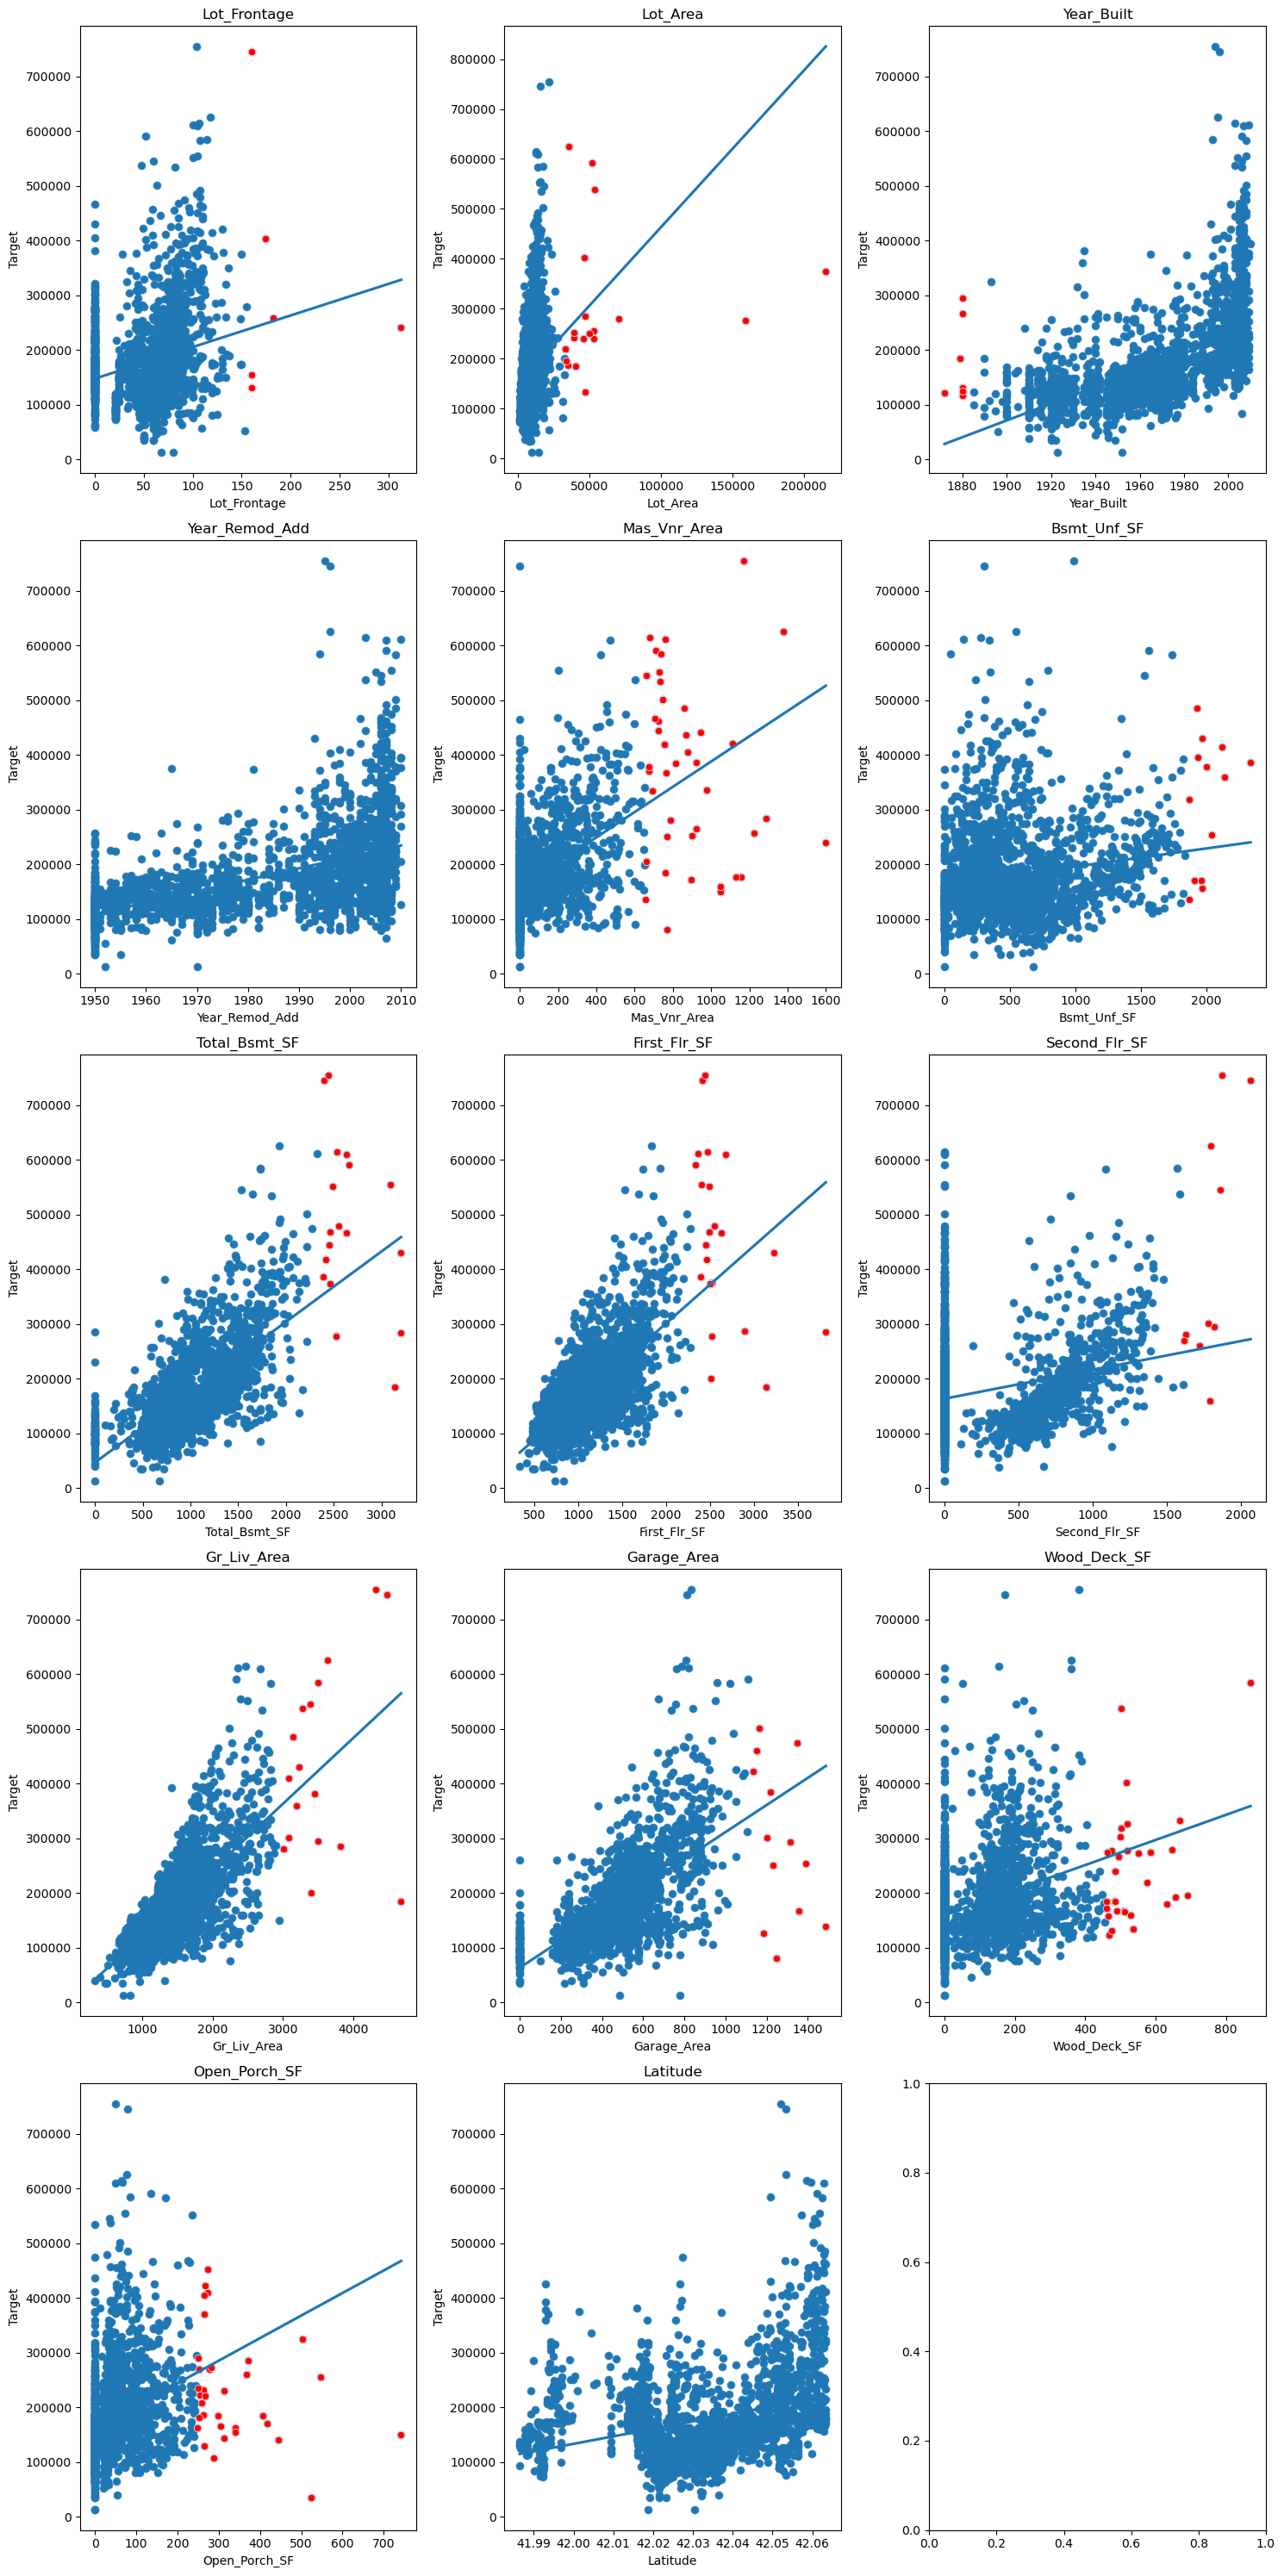

In [19]:
from scipy import stats

# Define the 6 features
# features = ['Gr_Liv_Area', 'Total_Bsmt_SF', 'First_Flr_SF',
            # 'Bsmt_Unf_SF', 'Lot_Area', 'Garage_Area']
features = ['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add',
       'Mas_Vnr_Area', 'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'First_Flr_SF',
       'Second_Flr_SF', 'Gr_Liv_Area', 'Garage_Area', 'Wood_Deck_SF',
       'Open_Porch_SF', 'Latitude']

# Create a figure and axis object
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 30))

# Loop through each feature
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    # Create a scatter plot
    sns.scatterplot(x=feature, y='Sale_Price', data=X_train_full, ax=ax)

    # Fit a linear line
    sns.regplot(x=feature, y='Sale_Price', data=X_train_full, ax=ax, ci=None)

    # Identify outliers using Z-score method
    z_scores = np.abs(stats.zscore(X_train_full[feature]))
    outliers = X_train_full[z_scores > 3]

    # Color outliers
    sns.scatterplot(x=feature, y='Sale_Price',
                    data=outliers, ax=ax, color='red')

    # Set title and labels
    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel('Target')

# Show the plot
plt.tight_layout()
plt.show()

### Linear regression models
#### Full Model

In [20]:
# full model with no penalty
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_opt, y_train_opt)

# verify the model with the test data
y_pred = model.predict(X_test_opt)
print(f"Full model score: {score_model(y_test_opt, y_pred):.5f} RMSE")


Full model score: 0.16570 RMSE


#### Lasso Regression

Lasso alpha: 0.00003
Lasso score: 0.16574 RMSE
alpha_min 3.199267137797385e-05
alpha_1se 0.000756463327554629
Lasso score with optimal alpha: 0.16751 RMSE


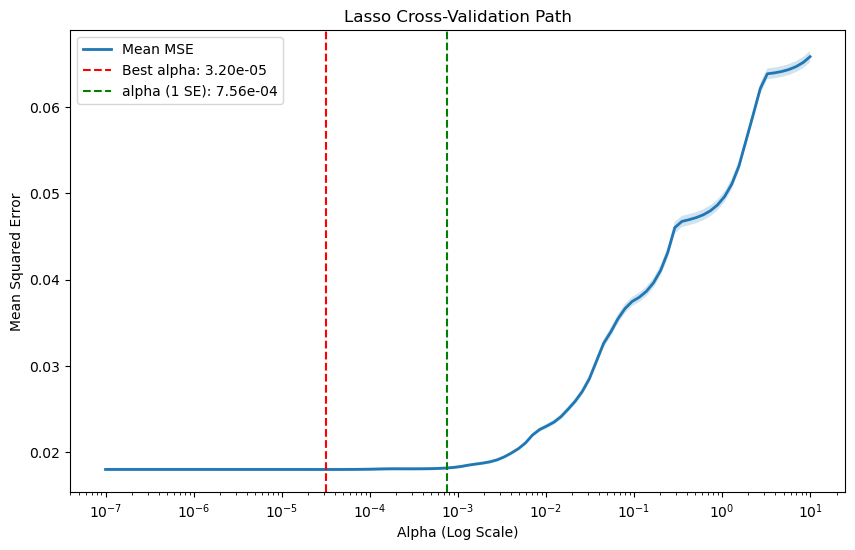

In [21]:
# Lasso Regression
from sklearn.linear_model import LassoCV, Lasso
lasso_alphas = np.logspace(-7, 1, 100)
lassoCV = LassoCV(alphas=lasso_alphas, cv=5, random_state=seed_val)
lassoCV.fit(X_train_opt, y_train_opt)
lasso_cv_alpha = lassoCV.alpha_
print(f"Lasso alpha: {lasso_cv_alpha:.5f}")

# verify the model with the test data
y_pred_lasso = lassoCV.predict(X_test_opt)
print(f"Lasso score: {score_model(y_test_opt, y_pred_lasso):.5f} RMSE")

n = len(X_train_opt.columns)
mean_mse = np.mean(lassoCV.mse_path_, axis=1)
std_mse = np.std(lassoCV.mse_path_, axis=1) / np.sqrt(n) 

cv_alphas = lassoCV.alphas_
min_idx = np.argmin(mean_mse)

alpha_min = cv_alphas[min_idx]

threshold = mean_mse[min_idx] + std_mse[min_idx]
alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

print("alpha_min", alpha_min)
print("alpha_1se", alpha_1se)

mean_mse = np.array(mean_mse)
std_mse = np.array(std_mse)

# Lasso with the optimal alpha
lasso_model_min = Lasso(alpha = alpha_1se, max_iter=10000)
lasso_model_min.fit(X_train_opt, y_train_opt)
y_pred_lasso_min = lasso_model_min.predict(X_test_opt)
print(f"Lasso score with optimal alpha: {score_model(y_test_opt, y_pred_lasso_min):.5f} RMSE")

plt.figure(figsize=(10, 6))
plt.semilogx(cv_alphas, mean_mse, label='Mean MSE', linewidth=2)
plt.fill_between(cv_alphas, mean_mse - std_mse, mean_mse + std_mse, alpha=0.2)
plt.axvline(alpha_min, linestyle='--', color='r', label=f'Best alpha: {alpha_min:.2e}')
plt.axvline(alpha_1se, linestyle='--', color='g', label=f'alpha (1 SE): {alpha_1se:.2e}')
plt.xlabel('Alpha (Log Scale)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Lasso Cross-Validation Path')
plt.show()

#### Ridge Regression


In [22]:
# ridge regression CV path plot
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV

In [23]:
ridge_alphas = np.logspace(-10, 1, 100)
ridgeCV = RidgeCV(alphas=ridge_alphas, cv=10, scoring='neg_root_mean_squared_error')
ridgeCV.fit(X_train_opt, y_train_opt)

# verify the model with the test data
y_pred_ridge = ridgeCV.predict(X_test_opt)
print(f"Ridge score: {score_model(y_test_opt, y_pred_ridge):.5f} RMSE")

Ridge score: 0.16581 RMSE


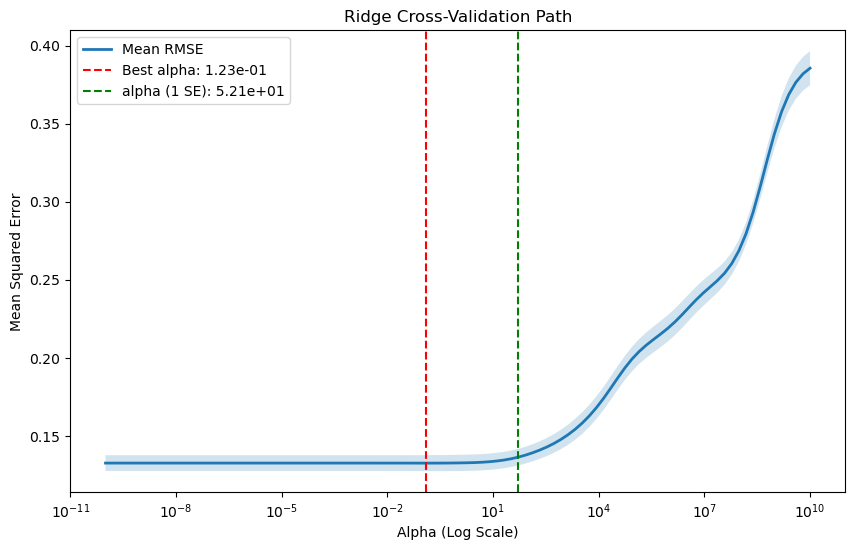

In [24]:
mean_rmse = []
std_rmse = []
ridge_alphas = np.logspace(-10, 10, 100)

for alpha in ridge_alphas:
    ridge = Ridge(alpha=alpha)
    rmse = -cross_val_score(ridge, X_train_opt, y_train_opt, cv=10, scoring='neg_root_mean_squared_error')
    mean_rmse.append(np.mean(rmse))
    std_rmse.append(np.std(rmse) / np.sqrt(10))

# Identify best alpha and one standard error rule alpha
min_idx = np.argmin(mean_rmse)
alpha_min = ridge_alphas[min_idx]

# Find the threshold within one standard error of the best alpha
threshold = mean_rmse[min_idx] + std_rmse[min_idx]

# Find the largest alpha within one standard error of the best alpha
one_se_rule_idx = np.where(mean_rmse <= threshold)[0][-1]
alpha_1se = ridge_alphas[one_se_rule_idx]

alpha_min, alpha_1se

mean_rmse = np.array(mean_rmse)
std_rmse = np.array(std_rmse)

plt.figure(figsize=(10, 6))
plt.semilogx(ridge_alphas, mean_rmse, label='Mean RMSE', linewidth=2)
plt.fill_between(ridge_alphas, mean_rmse - std_rmse, mean_rmse + std_rmse, alpha=0.2)
plt.axvline(alpha_min, linestyle='--', color='r', label=f'Best alpha: {alpha_min:.2e}')
plt.axvline(alpha_1se, linestyle='--', color='g', label=f'alpha (1 SE): {alpha_1se:.2e}')
plt.xlabel('Alpha (Log Scale)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Ridge Cross-Validation Path')
plt.show()

In [25]:
# retrain the ridge model with the optimal alpha
ridge_model_min = Ridge(alpha = alpha_min)
ridge_model_min.fit(X_train_opt, y_train_opt)
y_pred_ridge_min = ridge_model_min.predict(X_test_opt)
print(f"Ridge score with optimal alpha: {score_model(y_test_opt, y_pred_ridge_min):.5f} RMSE")


Ridge score with optimal alpha: 0.16581 RMSE


#### Elasticnet Regression

In [28]:
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(alphas=np.logspace(-7, 1, 100), cv=10, random_state=seed_val)
model.fit(X_train_opt, y_train_opt)

# verify the model with the test data
y_pred = model.predict(X_test_opt)
print(f"Elasticnet score: {score_model(y_test_opt, y_pred):.5f} RMSE")


Elasticnet score: 0.16572 RMSE


### Tree models
randomForest or boosting tree

In [29]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=seed_val)
model.fit(X_train_opt, y_train_opt)

# verify the model with the test data
y_pred = model.predict(X_test_opt)
print(f"Random Forest score: {score_model(y_test_opt, y_pred):.5f} RMSE")

Random Forest score: 0.14352 RMSE


In [31]:
# Boosting Tree
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=360, max_depth=10, learning_rate=0.1, random_state=seed_val)
model.fit(X_train_opt, y_train_opt)

# verify the model with the test data
y_pred = model.predict(X_test_opt)
print(f"Boosting Tree score: {score_model(y_test_opt, y_pred):.5f} RMSE")


XGBoostError: [01:30:20] /croot/xgboost-split_1724073744422/work/src/objective/objective.cc:31: Unknown objective function: `reg:rmse`
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: rank:ndcg
Objective candidate: rank:pairwise
Objective candidate: rank:map
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: reg:quantileerror
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:gamma
Objective candidate: reg:linear
Objective candidate: reg:pseudohubererror
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:tweedie
Objective candidate: reg:absoluteerror

Stack trace:
  [bt] (0) /home/lycpaul/anaconda3/envs/psl/lib/libxgboost.so(+0x1de354) [0x73fc687de354]
  [bt] (1) /home/lycpaul/anaconda3/envs/psl/lib/libxgboost.so(xgboost::ObjFunction::Create(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, xgboost::Context const*)+0x72c) [0x73fc68d4fd8c]
  [bt] (2) /home/lycpaul/anaconda3/envs/psl/lib/libxgboost.so(+0x5beecc) [0x73fc68bbeecc]
  [bt] (3) /home/lycpaul/anaconda3/envs/psl/lib/libxgboost.so(+0x5c9260) [0x73fc68bc9260]
  [bt] (4) /home/lycpaul/anaconda3/envs/psl/lib/libxgboost.so(+0x5cae24) [0x73fc68bcae24]
  [bt] (5) /home/lycpaul/anaconda3/envs/psl/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6c) [0x73fc687e425c]
  [bt] (6) /home/lycpaul/anaconda3/envs/psl/lib/python3.12/lib-dynload/../../libffi.so.8(+0xa052) [0x73fca96a3052]
  [bt] (7) /home/lycpaul/anaconda3/envs/psl/lib/python3.12/lib-dynload/../../libffi.so.8(+0x8925) [0x73fca96a1925]
  [bt] (8) /home/lycpaul/anaconda3/envs/psl/lib/python3.12/lib-dynload/../../libffi.so.8(ffi_call+0xde) [0x73fca96a206e]

